In [31]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

In [32]:
DATE = 250329
POZA = 'km11'
PATH_LAS = f'data/{DATE}_100m_7ms_100khz_plena_luz/pozas/{POZA}_100m_7ms_100khz_plena-luz_0_0.las' 

LIMIT = -1

rasantes = {
    'km11': 2300.382,  
    'km12': 2300.345,   
    'km13': 2300.372,
    '3a': 2300.305,
    '2a': 2300.700,
    'pam2': 2300.618  
}

rasante = rasantes.get(POZA, None)

In [40]:
las = read_las_file(PATH_LAS)
points = np.vstack((las.x, las.y, las.z)).transpose()
data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))

first = data_points[(data_points[:,-2] == 1) & (data_points[:,-1] == 2)]
salmuera = np.mean(first[:,2])
print(f'Cota Salmuera: {salmuera}')

one_return = data_points[(data_points[:, -1] == 1)][:, :3]
one_return = one_return[one_return[:,2] >= rasante] #remove noise
one_return = one_return[one_return[:,2] <= salmuera] #cota de la salmuera trap
one_return[:,2] = one_return[:,2] - rasante 

x, y, z = one_return[:,0],  one_return[:,1],  one_return[:,2] 

Cota Salmuera: 2301.1397392027266


In [54]:
x1, y1, z1 = one_return[:,0],  one_return[:,1],  one_return[:,2] - rasante

x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()

gsd = 0.05
resolution = 1 / gsd 
w = int(np.ceil((x1_max - x1_min)*resolution))
h = int(np.ceil((y1_max - y1_min)*resolution))

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, w),
    np.linspace(y1_min, y1_max, h)
)

# First interpolation using linear method
grid_z_linear = griddata((x1, y1), z, (grid_x, grid_y), method="linear") 

# Second interpolation using nearest method to ensure complete surface
grid_z_nearest = griddata((x1, y1), z, (grid_x, grid_y), method="nearest") 

# Combine the results to ensure complete surface
grid_z = np.where(np.isnan(grid_z_linear), grid_z_nearest, grid_z_linear)

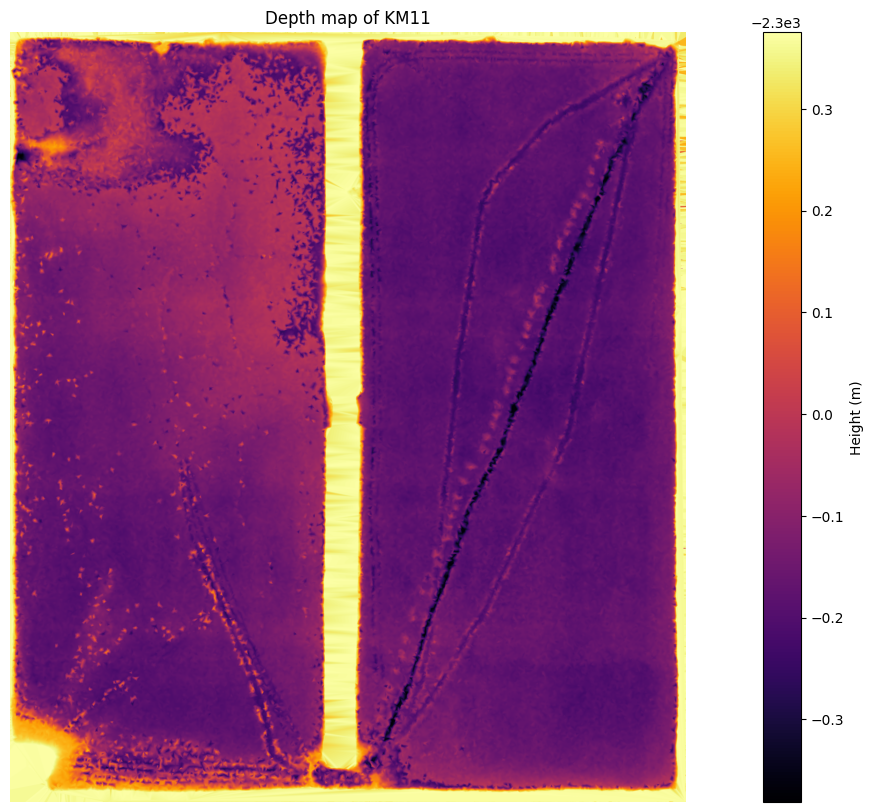

In [ ]:
# import matplotlib.colors as mcolors
# colors = ["green", "yellow", "orange", "red"]
# cmap = mcolors.LinearSegmentedColormap.from_list("green_yellow_orange_red", colors)


# Plotting the combined result
plt.figure(figsize=(20, 10))
plt.imshow(grid_z, origin='lower', cmap='inferno')
plt.colorbar(label='Height (m)')
plt.title(f'Depth map of {POZA.upper()}')
plt.axis('off') 
plt.show()            

In [57]:
z_save = grid_z.astype(np.float32) 
pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'dems/{POZA}.tiff')

In [70]:

h,w

(5720, 5015)